In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as data
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from datetime import datetime

In [2]:
start = pd.to_datetime(['2010-01-01']).astype(int)[0]//10**9 # convert to unix timestamp.
end = pd.to_datetime(['2021-12-31']).astype(int)[0]//10**9 # convert to unix timestamp.
stock_ticker = 'AAPL'
url = 'https://query1.finance.yahoo.com/v7/finance/download/' + stock_ticker + '?period1=' + str(start) + '&period2=' + str(end) + '&interval=1d&events=history'
df = pd.read_csv(url)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.535087,493729600
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.546384,601904800
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.442256,552160000
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.430346,477131200
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.473097,447610800


In [3]:
df = df.drop(['Date', 'Adj Close'], axis = 1)
df.head()

,Open,High,Low,Close,Volume
0,7.622500,7.660714,7.585000,7.643214,493729600
1,7.664286,7.699643,7.616071,7.656429,601904800
2,7.656429,7.686786,7.526786,7.534643,552160000
3,7.562500,7.571429,7.466071,7.520714,477131200
4,7.510714,7.571429,7.466429,7.570714,447610800


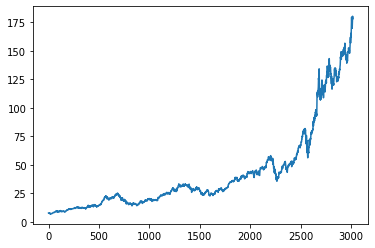

In [4]:
plt.plot(df.Close);

In [5]:
ma100 = df.Close.rolling(100).mean()
ma100

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
3015    153.0106
3016    153.3444
3017    153.6667
3018    153.9991
3019    154.3202
Name: Close, Length: 3020, dtype: float64

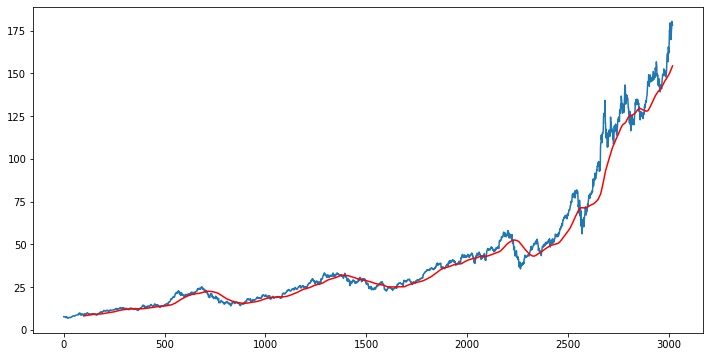

In [6]:
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100, 'r')

In [7]:
ma200 = df.Close.rolling(200).mean()
ma200

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
3015    142.55920
3016    142.85570
3017    143.13220
3018    143.40125
3019    143.66845
Name: Close, Length: 3020, dtype: float64

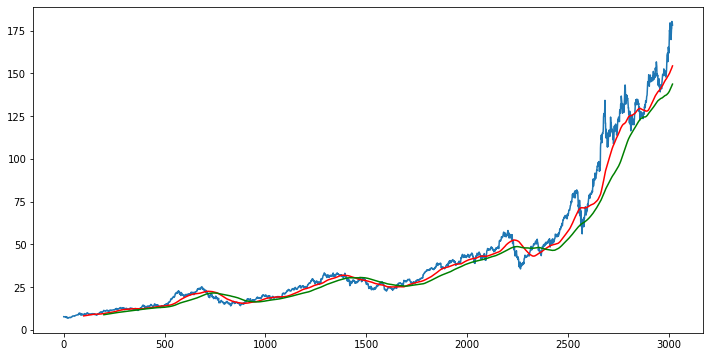

In [8]:
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100, 'r')
plt.plot(ma200, 'g')

In [9]:
# Splitting Data Into Training And Testing

In [10]:
data_training = pd.DataFrame(df['Close'][0:int(len(df)*0.70)])
data_testing = pd.DataFrame(df['Close'][int(len(df)*0.70): int(len(df))])

In [11]:
data_training.head()

,Close
0,7.643214
1,7.656429
2,7.534643
3,7.520714
4,7.570714


In [12]:
data_testing.head()

,Close
2114,46.974998
2115,46.875000
2116,46.717499
2117,47.560001
2118,47.957500


In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))

In [14]:
data_training_array = scaler.fit_transform(data_training)

In [15]:
x_train = []
y_train = []

for i in range(100, data_training.shape[0]):
  x_train.append(data_training_array[i - 100: i])
  y_train.append(data_training_array[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [16]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

In [17]:
model = Sequential()

model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units = 1))

In [18]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, epochs = 50)

Epoch 1/50
63/63 [==============================] - 36s 486ms/step - loss: 0.0314
Epoch 2/50
63/63 [==============================] - 20s 313ms/step - loss: 0.0083
Epoch 3/50
63/63 [==============================] - 17s 274ms/step - loss: 0.0064
Epoch 4/50
63/63 [==============================] - 17s 275ms/step - loss: 0.0069
Epoch 5/50
63/63 [==============================] - 19s 295ms/step - loss: 0.0063
Epoch 6/50
63/63 [==============================] - 17s 276ms/step - loss: 0.0062
Epoch 7/50
63/63 [==============================] - 20s 310ms/step - loss: 0.0052
Epoch 8/50
63/63 [==============================] - 17s 276ms/step - loss: 0.0055
Epoch 9/50
63/63 [==============================] - 18s 292ms/step - loss: 0.0045
Epoch 10/50
63/63 [==============================] - 18s 278ms/step - loss: 0.0049
Epoch 11/50
63/63 [==============================] - 17s 275ms/step - loss: 0.0044
Epoch 12/50
63/63 [==============================] - 18s 280ms/step - loss: 0.0046
Epoch 13/50
6

In [19]:
model.save('keras_model.h5')

In [20]:
past_100_days = data_training.tail(100)

In [21]:
final_df = past_100_days.append(data_testing, ignore_index = True)

In [22]:
input_data = scaler.fit_transform(final_df)

In [23]:
x_test = []
y_test = []

for i in range(100, input_data.shape[0]):
  x_test.append(input_data[i - 100: i])
  y_test.append(input_data[i,0])

In [24]:
x_test, y_test = np.array(x_test), np.array(y_test)

In [25]:
y_pred = model.predict(x_test)

In [26]:
y_predicted = y_pred /scaler.scale_
y_test = y_test /scaler.scale_

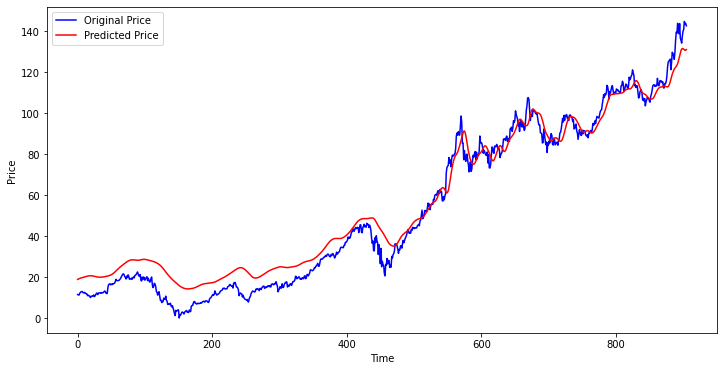

In [29]:
plt.figure(figsize = (12,6))
plt.plot(y_test, 'b', label = 'Original Price');
plt.plot(y_predicted, 'r', label = 'Predicted Price');
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()